In [2]:
from itertools import product

import numpy as np
import xarray as xr
from scipy import integrate
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pop_tools
import xpersist as xp
import dask

import util

In [3]:
variables = ['SST', 'Chl_surf', 'KGP']
ds = xr.open_zarr('data/cesm-le-djf-triregion-timeseries.zarr')
ds = ds[variables].sel(length = 40)
ds

<xarray.Dataset>
Dimensions:    (member_id: 34, region: 5, time: 180)
Coordinates:
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
  * region     (region) <U17 'Southern Ocean' 'WAP & Atlantic' ... 'AP Sector'
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
    length     float64 40.0
Data variables:
    SST        (time, member_id, region) float64 dask.array<chunksize=(180, 34, 5), meta=np.ndarray>
    Chl_surf   (time, member_id, region) float64 dask.array<chunksize=(180, 34, 5), meta=np.ndarray>
    KGP        (time, member_id, region) float64 dask.array<chunksize=(90, 34, 5), meta=np.ndarray>

### Write Assess ToE Function

In [4]:
def assess_toe(da):
    """ compute toe on the basis of henson et al 2017
    
    To calculate the ToE, ﬁrst the time series of annual extrema in the conjoined historical
    and warming scenario runs is created. Then, an inﬂection point is located by calculating
    the cumulative sum of the gradient in Yt (qY/qt) and identifying the year when it
    exceeds zero (for a positive trend) or drops below zero (for a negative trend) for the
    remainder of the time series—we refer to this as the start of the climate change signal
    The trend in Yt is then calculated from that start point forward to 2100 using numpy's polyfit function.
    
    The natural variability (or noise) is deﬁned as one standard deviation in annual extrema 
    of a 100-year section of the model’s control run. As a consequence, the natural variability 
    as deﬁned here accounts for only the unforced natural variability,
    excluding the inﬂuence of changing incoming solar radiation or volcanoes.
    The ToE is then deﬁned as: ToE = (2 σ) / slope
    """
    # compute anomalies
    da_ref = da.sel(time=slice(1920, 1950)).mean(['time', 'member_id']).values
    da_ref_std = da.sel(time=slice(1920, 1950)).std(['time', 'member_id']).values
    anom = da.mean('member_id') - da_ref

    # Calculate cumulative integral
    time = da.time.values
    anom_cumtrapz = integrate.cumtrapz(anom.values, time, initial=0)
    
    # creates a boolean array where values of the anomaly @ the 'end' of the time series 
    # that are greater than zero are assigned a 1 and less than zero are assigned a -1 everywhere else
    int_sign = np.where(anom.isel(time=-1).values > 0, 1, -1)

    # find the inflection point
    int_thresh = anom_cumtrapz * int_sign 
    
    ndx = None
    for l in range (len(time)):
           if all (int_thresh[l:] > 0):
        #if all (np.abs(int_thresh[l:]) > 0):
            ndx = l
            break #once it finds the year where the trend declines, break, then...
    # compute trend year and slope after inflection point
    if ndx is None:
        return tuple(np.nan for i in range(5))
    cc_yr = time[ndx]

    beta = np.polyfit(time[ndx:], anom[ndx:], 1)
    cc_slope = beta[0]
    cc_intercept = beta[1]

    # compute time of emergence: ToE = (2 σ) / slope
    toe = np.abs((2 * da_ref_std) / cc_slope)
    # calculate year of ToE (as an integral)
    toe_yr = int(cc_yr + toe)
    
    return time[ndx], cc_slope, cc_intercept, toe_yr,  toe

### Test across variables

In [5]:
print('Calculated Values \n(start of climate change, slope, intercept, year of emergence, pace)')
print('KGP:', assess_toe(ds.KGP.sel(region='Southern Ocean').compute()))
print('Chl:', assess_toe(ds.Chl_surf.sel(region='Southern Ocean').compute()))
print('SST:', assess_toe(ds.SST.sel(region='Southern Ocean').compute()))

Calculated Values 
(start of climate change, slope, intercept, year of emergence, pace)
KGP: (1951, -3.389687388300565e-05, 0.06706854630450108, 2095, 144.07687883203775)
Chl: (2006, -0.0009898208422373044, 1.9902113414289535, 2095, 89.77146824538589)
SST: (1950, 0.02023557793552905, -39.95519861361217, 1969, 19.812015068165536)


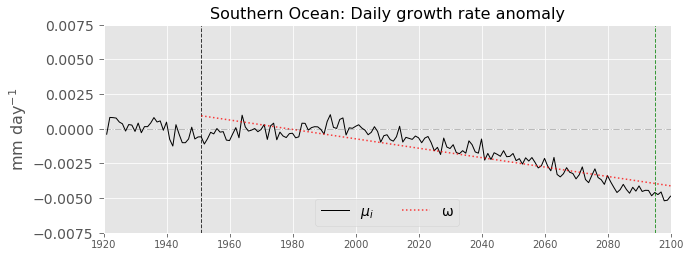

In [6]:
# ♫ ♩ Choose your character ♩ ♫
plt.style.use('ggplot')
v = 'KGP'
unit = 'mm day$^{-1}$'
limYMin, limYMax = -0.0075, 0.0075
region= 'Southern Ocean'
ds_plot = ds.sel(region = region)

###########   Set up a plot  ##############
gs = gridspec.GridSpec(2,1)
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
ax.set_ylim((limYMin, limYMax))
#~~~~~~~~~~~~   Plot   ~~~~~~~~~~~~~~~~~~
# plot ensemble mean
mean_anom = ds_plot.mean('member_id') - ds_plot.sel(time=slice(1920, 1950)).mean(dim=['time', 'member_id']).compute()
ax.plot(ds_plot.time, mean_anom[v],'-', linewidth=1, color='k', label = '$\mu_i$') # ensemble mean

# calculate and plot reference lines: start of climate change and toe
cc_year, cc_slope, cc_int, toe_yr, pace = assess_toe(ds[v].sel(region=region).compute())
ax.axvline(cc_year, lw=1, color='k', linestyle='--', alpha = .75)
ax.axvline(toe_yr, lw=1, color='g', linestyle='--', alpha = .75)

# Calculate and Plot Best Fit of Climate Change
# Create a list of values in the best fit line
abline_values = [cc_slope * i + cc_int for i in ds_plot.sel(time=slice(cc_year, 2100)).time]
ax.plot(ds_plot.sel(time=slice(cc_year, 2100)).time, abline_values, 'r', linestyle=':', alpha = .75, label = 'ω')

#~~~~~~~~~~~ Finess the plot details ~~~~~~~~~~~~~~~~
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .25)
ax.set_ylabel(unit, fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
title = f'{region}: {ds[v].long_name} anomaly'
ax.set_title(title, fontsize = 16);
ax.legend(ncol = 3, fontsize = 14)
gs.update(hspace=.2, top=.92, right=1)

## Load DJF dataset

In [7]:
variables = ['SST', 'Chl_surf', 'KGP']

ds_djf = xr.open_zarr(f'{util.project_tmpdir}/cesm-le-fields-djf.zarr')
ds_djf = ds_djf[variables].sel(length = 40).compute()
ds_djf

<xarray.Dataset>
Dimensions:    (member_id: 34, nlat: 93, nlon: 320, time: 180)
Coordinates:
    KMT        (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 53.0 53.0 53.0 54.0
    length     float64 40.0
    ULONG      (nlat, nlon) float64 321.1 322.3 323.4 ... 317.8 318.9 320.0
    TLONG      (nlat, nlon) float64 320.6 321.7 322.8 ... 317.2 318.3 319.4
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
    TLAT       (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08
    TAREA      (nlat, nlon) float64 1.125e+13 1.125e+13 ... 6.346e+13 6.346e+13
    ULAT       (nlat, nlon) float64 -78.95 -78.95 -78.95 ... -29.82 -29.82
Dimensions without coordinates: nlat, nlon
Data variables:
    SST        (time, member_id, nlat, nlon) float64 0.0 0.0 0.0 ... 26.37 26.27
    Chl_surf   (time, member_id, nlat, nlon) float64 0.0 0.0 ... 0.06473 0.06521
    KGP        (time, member_id, nlat, nlon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [8]:
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
try:
    cluster
    client
except:
    cluster = NCARCluster(project='UCUC0006')
    cluster.scale(35)
    client = Client(cluster) # Connect this local process to remote workers
client

Client Scheduler: tcp://10.12.205.27:41610 Dashboard: https://jupyterhub.ucar.edu/dav/user/zephyrs/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [29]:
%%time
max_jobs = 3000
ds_toe = xr.Dataset()
for v in ['SST','KGP','Chl_surf']:
    # stack lateral dims
    da = ds_djf[v].stack(non_time_dims=[d for d in ds_djf[v].dims if d not in ['time', 'member_id']])
    # initialize temporary variables
    da_inflection_stack = da.isel(time=0, member_id=0, drop=True)   
    da_slope_stack = da.isel(time=0, member_id=0, drop=True)
    da_intercept_stack = da.isel(time=0, member_id=0, drop=True)
    da_toe_stack = da.isel(time=0, member_id=0, drop=True)
    da_toetime_stack = da.isel(time=0, member_id=0, drop=True)

    # loop over non time dims; compute ToE
    delayed_obj= []
    results= []

    for i in range(len(da.non_time_dims)):
        delayed_obj.append(dask.delayed(assess_toe)(da.isel(non_time_dims=i)))  
        if len(delayed_obj) == max_jobs:
            results.extend(dask.compute(*delayed_obj))
            delayed_obj= []

    if delayed_obj:
        results.extend(dask.compute(*delayed_obj))
        delayed_obj= []

    # time[ndx], cc_slope, cc_intercept, toe_yr,  toe
    da_inflection_stack.data = np.array([r[0] for r in results]).astype(np.float)
    da_slope_stack.data = np.array([r[1] for r in results]).astype(np.float)
    da_intercept_stack.data = np.array([r[2] for r in results]).astype(np.float)
    da_toe_stack.data = np.array([r[3] for r in results]).astype(np.float)
    da_toetime_stack.data = np.array([r[4] for r in results]).astype(np.float)

    # assign to output dataset
    ds_toe[f'{v}_inflect'] = da_inflection_stack.unstack('non_time_dims')
    ds_toe[f'{v}_slope'] = da_slope_stack.unstack('non_time_dims')
    ds_toe[f'{v}_intercept'] = da_intercept_stack.unstack('non_time_dims')
    ds_toe[f'{v}_toe'] = da_toe_stack.unstack('non_time_dims')
    ds_toe[f'{v}_toetime'] = da_toetime_stack.unstack('non_time_dims')
    
ds_toe = ds_toe.where(ds_toe.KMT > 0)

CPU times: user 2min 57s, sys: 40 s, total: 3min 37s
Wall time: 7min 27s


In [31]:
ds_toe

<xarray.Dataset>
Dimensions:             (nlat: 93, nlon: 320)
Coordinates:
    KMT                 (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 53.0 53.0 54.0
    length              float64 40.0
    ULONG               (nlat, nlon) float64 321.1 322.3 323.4 ... 318.9 320.0
    TLONG               (nlat, nlon) float64 320.6 321.7 322.8 ... 318.3 319.4
    TLAT                (nlat, nlon) float64 -79.22 -79.22 ... -30.08 -30.08
    TAREA               (nlat, nlon) float64 1.125e+13 1.125e+13 ... 6.346e+13
    ULAT                (nlat, nlon) float64 -78.95 -78.95 ... -29.82 -29.82
  * nlat                (nlat) int64 0 1 2 3 4 5 6 7 ... 85 86 87 88 89 90 91 92
  * nlon                (nlon) int64 0 1 2 3 4 5 6 ... 314 315 316 317 318 319
Data variables:
    SST_inflect         (nlat, nlon) float64 nan nan nan ... 1.951e+03 1.951e+03
    SST_slope           (nlat, nlon) float64 nan nan nan ... 0.0216 0.0215
    SST_intercept       (nlat, nlon) float64 nan nan nan ... -42.64 -42.44
    SST_toe             (nlat, nlon) float64 nan nan nan ... 1.992e+03 1.992e+03
    SST_toetime         (nlat, nlon) float64 nan nan nan ... 41.01 41.12 41.48
    KGP_inflect         (nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    KGP_slope           (nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    KGP_intercept       (nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    KGP_toe             (nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    KGP_toetime         (nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    Chl_surf_inflect    (nlat, nlon) float64 nan nan nan ... 2.024e+03 2.034e+03
    Chl_surf_slope      (nlat, nlon) float64 nan nan ... -0.0004322 -0.000452
    Chl_surf_intercept  (nlat, nlon) float64 nan nan nan ... 0.8749 0.9177
    Chl_surf_toe        (nlat, nlon) float64 nan nan nan ... 2.038e+03 2.048e+03
    Chl_surf_toetime    (nlat, nlon) float64 nan nan nan ... 15.95 14.41 14.08

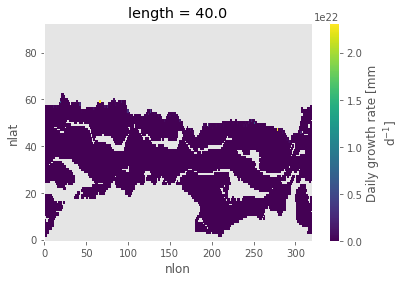

In [32]:
ds_toe.KGP_toe.plot()

In [43]:
print(int(ds_toe.KGP_toe.max().values))
print(int(ds_toe.Chl_surf_toe.max().values))
print(int(ds_toe.SST_toe.max().values))


23113670840384464355328
9073948
2204


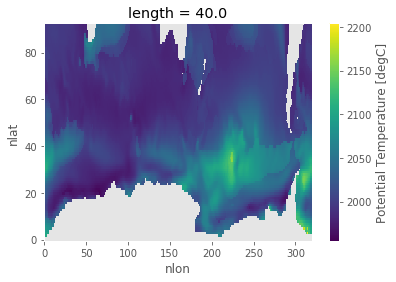

In [33]:
ds_toe.SST_toe.plot()

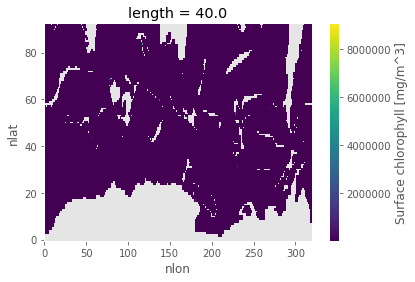

In [34]:
ds_toe.Chl_surf_toe.plot()

In [30]:
util.write_ds_out(ds_toe, f'data/cesm-le-fields-djf-Henson-ToE-maps.zarr')

------------------------------
Writing /glade/u/home/zephyrs/projects/krill-cesm-le/notebooks/data/cesm-le-fields-djf-Henson-ToE-maps.zarr
xarray.Dataset {
dimensions:
	nlat = 93 ;
	nlon = 320 ;

variables:
	float64 SST_inflect(nlat, nlon) ;
		SST_inflect:cell_methods = time: mean ;
		SST_inflect:grid_loc = 3111 ;
		SST_inflect:long_name = Potential Temperature ;
		SST_inflect:units = degC ;
	float64 SST_slope(nlat, nlon) ;
		SST_slope:cell_methods = time: mean ;
		SST_slope:grid_loc = 3111 ;
		SST_slope:long_name = Potential Temperature ;
		SST_slope:units = degC ;
	float64 SST_intercept(nlat, nlon) ;
		SST_intercept:cell_methods = time: mean ;
		SST_intercept:grid_loc = 3111 ;
		SST_intercept:long_name = Potential Temperature ;
		SST_intercept:units = degC ;
	float64 SST_toe(nlat, nlon) ;
		SST_toe:cell_methods = time: mean ;
		SST_toe:grid_loc = 3111 ;
		SST_toe:long_name = Potential Temperature ;
		SST_toe:units = degC ;
	float64 SST_toetime(nlat, nlon) ;
		SST_toetime:cell_methods